In [1]:
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import gym
from gym.envs.toy_text.frozen_lake import generate_random_map

import gambler_env
import gambler_utils
import frozen_lake_utils

import warnings
warnings.filterwarnings('ignore')

In [2]:
FIG_PATH = 'figures/'

RANDOM_SEED = 17
ENV_NAME = "frozen_lake"

### Plotting functions

In [3]:
def plot_comparison_bars(ax, list_data1, list_data2, list_xlabels, 
                         title, ylabels, xlabels="State size", 
                         label1="Frozen lake", label2="Gambler", 
                         yerr_std1=None, yerr_std2=None):

    x = np.arange(len(list_xlabels))  # the label locations
    width = 0.3  # the width of the bars

    rects1 = ax.bar(x - width/2, list_data1, width, label=label1, yerr=yerr_std1)
    rects2 = ax.bar(x + width/2, list_data2, width, label=label2, yerr=yerr_std2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabels)
    ax.set_xlabel(xlabels)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(list_xlabels)
    ax.legend()
    ax.set_ylim(0, None)

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', 
                        color='black')#, fontweight='bold')

    autolabel(rects1)
    autolabel(rects2)


def plot_all_comparison_bars(list_stats_frozen_lake, list_stats_gambler, list_xlabels, algo_type=""):
    fig, ax = plt.subplots(1, 3, figsize=(18,6))

    title = f"{algo_type}: Running time per state size"
    ylabels = "Running time (s)"
    list_data1 = list_stats_frozen_lake[:, 0].round(decimals=4)
    list_data2 = list_stats_gambler[:, 0].round(decimals=4)
    plot_comparison_bars(ax[0], list_data1, list_data2, list_xlabels, title, ylabels)

    title = f"{algo_type}: Max iterations per state size"
    ylabels = "Max iterations"
    list_data1 = list_stats_frozen_lake[:, 1].round(decimals=4)
    list_data2 = list_stats_gambler[:, 1].round(decimals=4)
    plot_comparison_bars(ax[1], list_data1, list_data2, list_xlabels, title, ylabels)

    title = f"{algo_type}: Success rate per state size"
    ylabels = "Success rate (%)"
    list_data1 = list_stats_frozen_lake[:, 2].round(decimals=4)
    list_data2 = list_stats_gambler[:, 2].round(decimals=4)
    yerr_std1 = list_stats_frozen_lake[:, 3].round(decimals=4)
    yerr_std2 = list_stats_gambler[:, 3].round(decimals=4)
    plot_comparison_bars(ax[2], list_data1, list_data2, list_xlabels, title, ylabels, yerr_std1=yerr_std1, yerr_std2=yerr_std2)

    fig.tight_layout()
    plt.savefig(FIG_PATH+f"stats_comparison_bars_{algo_type}")
    plt.show()


def plot_discount_comparison_bars(list_stats_frozen_lake, list_stats_gambler, list_xlabels, algo_type=""):
    fig, ax = plt.subplots(1, 3, figsize=(18,6))

    title = f"{algo_type}: Running time per Discount factor"
    ylabels = "Running time (s)"
    list_data1 = list_stats_frozen_lake[:, 0].round(decimals=4)
    list_data2 = list_stats_gambler[:, 0].round(decimals=4)
    plot_comparison_bars(ax[0], list_data1, list_data2, list_xlabels, title, ylabels, xlabels="Discount factor")

    title = f"{algo_type}: Mean reward per Discount factor"
    ylabels = "Mean reward"
    list_data1 = list_stats_frozen_lake[:, 4].round(decimals=4)
    list_data2 = list_stats_gambler[:, 4].round(decimals=4)
    plot_comparison_bars(ax[1], list_data1, list_data2, list_xlabels, title, ylabels, xlabels="Discount factor")

    title = f"{algo_type}: Success rate per Discount factor"
    ylabels = "Success rate (%)"
    list_data1 = list_stats_frozen_lake[:, 2].round(decimals=4)
    list_data2 = list_stats_gambler[:, 2].round(decimals=4)
    yerr_std1 = list_stats_frozen_lake[:, 3].round(decimals=4)
    yerr_std2 = list_stats_gambler[:, 3].round(decimals=4)
    plot_comparison_bars(ax[2], list_data1, list_data2, list_xlabels, title, ylabels, 
                         yerr_std1=yerr_std1, yerr_std2=yerr_std2, xlabels="Discount factor")

    fig.tight_layout()
    plt.savefig(FIG_PATH+f"stats_comparison_bars_{algo_type}_discount")
    plt.show()

## Hyperparameters Gridsearch

In [4]:
# Final Envs for gridsearch
np.random.seed(RANDOM_SEED)

list_frozen_lake_env_final = []
list_gambler_env_final = []

list_state_size_discount = [(4, 20)] #(8, 100), 
list_discount = [0.5, 0.7, 0.9, 0.995, 0.9995]

for state_size in list_state_size_discount:
    map_size = state_size[0]
    new_map = generate_random_map(size=map_size, p=0.8) if map_size == 8 else None
    env_fl = gym.make('FrozenLake-v0', desc=new_map)
    list_frozen_lake_env_final.append(env_fl)

    goal_cash = state_size[1]
    initial_cash_in_hand = int(goal_cash/4)
    env_gambler = gambler_env.GamblersEnv(initial_cash_in_hand=initial_cash_in_hand, goal_cash=goal_cash)
    list_gambler_env_final.append(env_gambler)


### Hyperparameters Gridsearch for VI

In [5]:
%%time
#[[running_time, max_iteration, mean_score, std_score]]
list_stats_frozen_lake = []
list_stats_gambler = []

for discount_factor in list_discount:
    print(f"\nComputing for discount_factor: {discount_factor}...")
    for idx in range(len(list_state_size_discount)):
        env = list_frozen_lake_env_final[idx]
        V_vi, policy_vi, stats_vi = frozen_lake_utils.value_iteration_function(env, discount_factor=discount_factor, max_iterations=2000)
        stats_final_vi = frozen_lake_utils.play_function(env, policy_vi)
        list_stats_frozen_lake.append([stats_vi['running_time'], stats_vi['max_iteration'],
                                       stats_final_vi['mean_score'], stats_final_vi['std_score'],
                                       stats_vi['mean_reward']])

        env = list_gambler_env_final[idx]
        V_vi, policy_vi, stats_vi = gambler_utils.value_iteration_function(env, discount_factor=discount_factor, max_iterations=2000)
        stats_final_vi = gambler_utils.play_function(env, policy_vi)
        list_stats_gambler.append([stats_vi['running_time'], stats_vi['max_iteration'],
                                   stats_final_vi['mean_score'], stats_final_vi['std_score'],
                                   stats_vi['mean_reward']])

list_stats_frozen_lake_discount_vi = np.array(list_stats_frozen_lake)
list_stats_gambler_discount_vi = np.array(list_stats_gambler)


Computing for discount_factor: 0.5...

Computing for discount_factor: 0.7...

Computing for discount_factor: 0.9...

Computing for discount_factor: 0.995...

Computing for discount_factor: 0.9995...
Wall time: 34.8 s


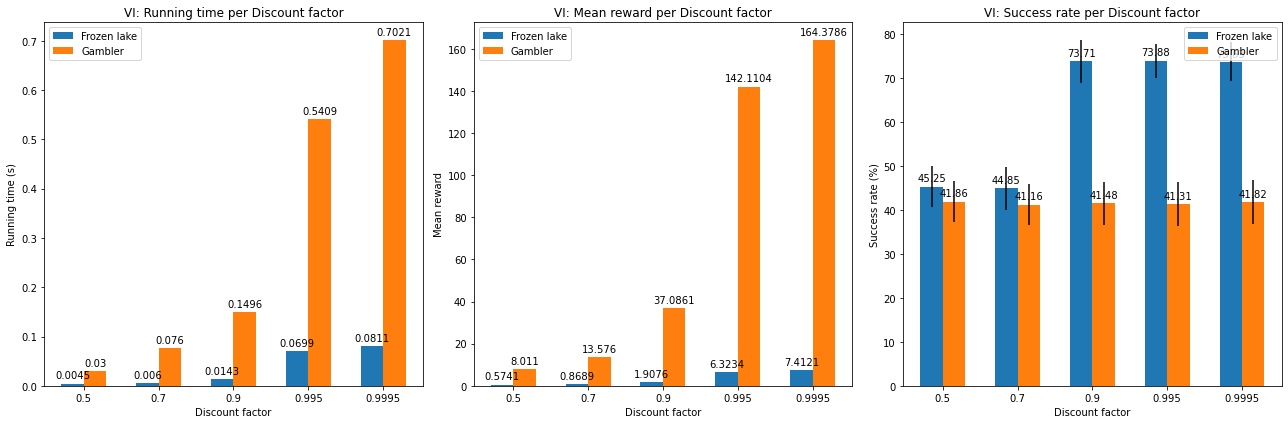

In [6]:
plot_discount_comparison_bars(list_stats_frozen_lake_discount_vi, list_stats_gambler_discount_vi, 
                              list_xlabels=list_discount, algo_type="VI")

### Hyperparameters Gridsearch for PI

In [7]:
%%time
#[[running_time, max_iteration, mean_score, std_score]]
list_stats_frozen_lake = []
list_stats_gambler = []

for discount_factor in list_discount:
    print(f"\nComputing for discount_factor: {discount_factor}...")
    for idx in range(len(list_state_size_discount)):
        env = list_frozen_lake_env_final[idx]
        V_vi, policy_vi, stats_vi = frozen_lake_utils.policy_iteration_function(env, discount_factor=discount_factor, 
                                                                                max_iterations_hl=20, max_iterations_ll=2000)
        stats_final_vi = frozen_lake_utils.play_function(env, policy_vi)
        list_stats_frozen_lake.append([stats_vi['running_time'], stats_vi['max_iteration'],
                                       stats_final_vi['mean_score'], stats_final_vi['std_score'],
                                       stats_vi['mean_reward']])

        env = list_gambler_env_final[idx]
        V_vi, policy_vi, stats_vi = gambler_utils.policy_iteration_function(env, discount_factor=discount_factor, 
                                                                                max_iterations_hl=20, max_iterations_ll=2000)
        stats_final_vi = gambler_utils.play_function(env, policy_vi)
        list_stats_gambler.append([stats_vi['running_time'], stats_vi['max_iteration'],
                                   stats_final_vi['mean_score'], stats_final_vi['std_score'],
                                   stats_vi['mean_reward']])

list_stats_frozen_lake_discount_pi = np.array(list_stats_frozen_lake)
list_stats_gambler_discount_pi = np.array(list_stats_gambler)


Computing for discount_factor: 0.5...

Computing for discount_factor: 0.7...

Computing for discount_factor: 0.9...

Computing for discount_factor: 0.995...

Computing for discount_factor: 0.9995...
Wall time: 33.6 s


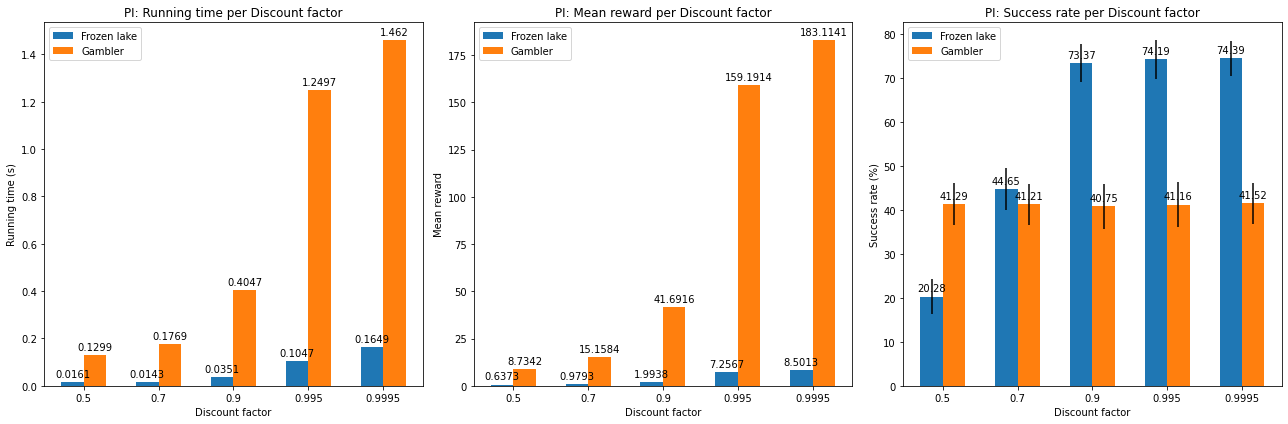

In [8]:
plot_discount_comparison_bars(list_stats_frozen_lake_discount_pi, list_stats_gambler_discount_pi, 
                              list_xlabels=list_discount, algo_type="PI")

### Hyperparameters Gridsearch for QL

In [9]:
%%time
#[[running_time, max_iteration, mean_score, std_score]]
list_stats_frozen_lake = []
list_stats_gambler = []

for discount_factor in list_discount:
    print(f"\nComputing for discount_factor: {discount_factor}...")
    for idx in range(len(list_state_size_discount)):
        env = list_frozen_lake_env_final[idx]
        V_vi, policy_vi, stats_vi = frozen_lake_utils.q_learning_function(env, num_episodes=15000, 
                                                                          discount_factor=discount_factor, 
                                                                          learning_rate_decay=0.9997, epsilon_decay=0.9995, 
                                                                          do_plot=False)
        stats_final_vi = frozen_lake_utils.play_function(env, policy_vi)
        list_stats_frozen_lake.append([stats_vi['running_time'], stats_vi['max_iteration'], 
                                       stats_final_vi['mean_score'], stats_final_vi['std_score'],
                                       stats_vi['mean_reward']])

        env = list_gambler_env_final[idx]
        V_vi, policy_vi, stats_vi = gambler_utils.q_learning_function(env, num_episodes=15000, 
                                                                      discount_factor=discount_factor, 
                                                                      learning_rate_decay=0.9997, epsilon_decay=0.9995, 
                                                                      do_plot=False)
        stats_final_vi = gambler_utils.play_function(env, policy_vi)
        list_stats_gambler.append([stats_vi['running_time'], stats_vi['max_iteration'],
                                   stats_final_vi['mean_score'], stats_final_vi['std_score'],
                                   stats_vi['mean_reward']])

list_stats_frozen_lake_discount_ql = np.array(list_stats_frozen_lake)
list_stats_gambler_discount_ql = np.array(list_stats_gambler)


Computing for discount_factor: 0.5...

Computing for discount_factor: 0.7...

Computing for discount_factor: 0.9...

Computing for discount_factor: 0.995...

Computing for discount_factor: 0.9995...
Wall time: 2min 37s


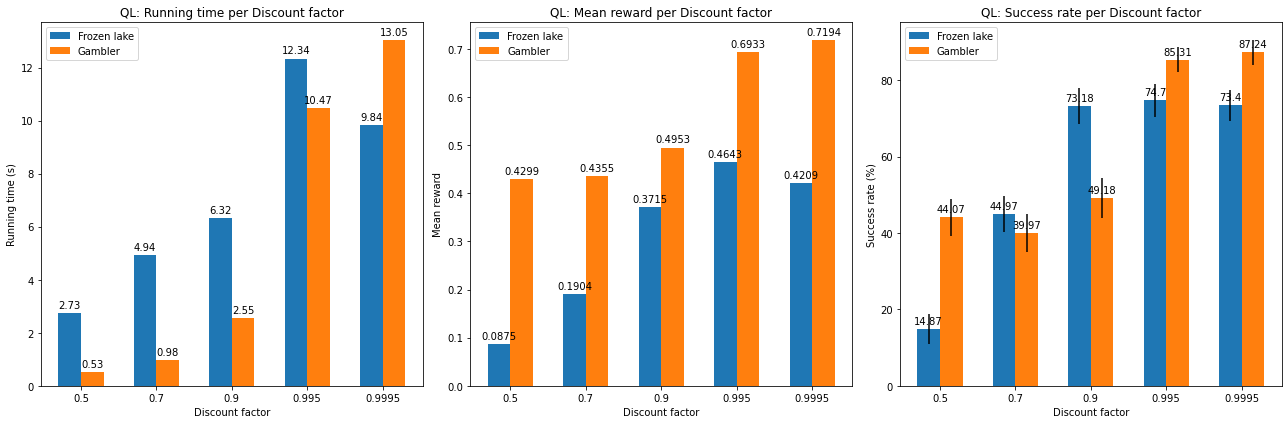

In [10]:
plot_discount_comparison_bars(list_stats_frozen_lake_discount_ql, list_stats_gambler_discount_ql, 
                              list_xlabels=list_discount, algo_type="QL")

## Algorithms comparison

In [11]:
# Envs for analysis
np.random.seed(RANDOM_SEED)

list_frozen_lake_env = []
list_gambler_env = []

list_state_size = [4, 8, 16, 32]

for state_size in list_state_size:
    new_map = generate_random_map(size=state_size, p=0.8)
    env_fl = gym.make('FrozenLake-v0', desc=new_map)
    list_frozen_lake_env.append(env_fl)

    goal_cash = state_size*3
    initial_cash_in_hand = int(goal_cash/4)
    env_gambler = gambler_env.GamblersEnv(initial_cash_in_hand=initial_cash_in_hand, goal_cash=goal_cash)
    list_gambler_env.append(env_gambler)


### VI stats

In [12]:
%%time
#[[running_time, max_iteration, mean_score, std_score]]
list_stats_frozen_lake = [] 
list_stats_gambler = []

for idx in range(len(list_state_size)):
    print(f"Computing for state size: {list_state_size[idx]}...")
    env = list_frozen_lake_env[idx]
    V_vi, policy_vi, stats_vi = frozen_lake_utils.value_iteration_function(env, discount_factor=0.995, max_iterations=2000)
    stats_final_vi = frozen_lake_utils.play_function(env, policy_vi)
    list_stats_frozen_lake.append([stats_vi['running_time'], stats_vi['max_iteration'], 
                                   stats_final_vi['mean_score'], stats_final_vi['std_score']])

    env = list_gambler_env[idx]
    V_vi, policy_vi, stats_vi = gambler_utils.value_iteration_function(env, discount_factor=0.995, max_iterations=2000)
    stats_final_vi = gambler_utils.play_function(env, policy_vi)
    list_stats_gambler.append([stats_vi['running_time'], stats_vi['max_iteration'],
                               stats_final_vi['mean_score'], stats_final_vi['std_score']])

list_stats_frozen_lake_vi = np.array(list_stats_frozen_lake)
list_stats_gambler_vi = np.array(list_stats_gambler)

Computing for state size: 4...
Computing for state size: 8...
Computing for state size: 16...
Computing for state size: 32...
Wall time: 1min 25s


### PI stats

In [13]:
%%time
#[[running_time, max_iteration, mean_score, std_score]]
list_stats_frozen_lake = [] 
list_stats_gambler = []

for idx in range(len(list_state_size)):
    print(f"Computing for state size: {list_state_size[idx]}...")
    env = list_frozen_lake_env[idx]
    V_vi, policy_vi, stats_vi = frozen_lake_utils.policy_iteration_function(env, discount_factor=0.995, 
                                                                            max_iterations_hl=20, max_iterations_ll=2000)
    stats_final_vi = frozen_lake_utils.play_function(env, policy_vi)
    list_stats_frozen_lake.append([stats_vi['running_time'], stats_vi['max_iteration'], 
                                   stats_final_vi['mean_score'], stats_final_vi['std_score']])

    env = list_gambler_env[idx]
    V_vi, policy_vi, stats_vi = gambler_utils.policy_iteration_function(env, discount_factor=0.995, 
                                                                            max_iterations_hl=20, max_iterations_ll=2000)
    stats_final_vi = gambler_utils.play_function(env, policy_vi)
    list_stats_gambler.append([stats_vi['running_time'], stats_vi['max_iteration'],
                               stats_final_vi['mean_score'], stats_final_vi['std_score']])

list_stats_frozen_lake_pi = np.array(list_stats_frozen_lake)
list_stats_gambler_pi = np.array(list_stats_gambler)

Computing for state size: 4...
Computing for state size: 8...
Computing for state size: 16...
Computing for state size: 32...
Wall time: 2min 30s


### Q-learning stats

In [14]:
%%time
#[[running_time, max_iteration, mean_score, std_score]]
list_stats_frozen_lake = []
list_stats_gambler = []

for idx in range(len(list_state_size)):
    print(f"Computing for state size: {list_state_size[idx]}...")
    env = list_frozen_lake_env[idx]
    V_vi, policy_vi, stats_vi = frozen_lake_utils.q_learning_function(env, num_episodes=15000, discount_factor=0.995, 
                                                                      learning_rate_decay=0.9997, epsilon_decay=0.9995, 
                                                                      do_plot=False)
    stats_final_vi = frozen_lake_utils.play_function(env, policy_vi)
    list_stats_frozen_lake.append([stats_vi['running_time'], stats_vi['max_iteration'], 
                                   stats_final_vi['mean_score'], stats_final_vi['std_score']])

    env = list_gambler_env[idx]
    V_vi, policy_vi, stats_vi = gambler_utils.q_learning_function(env, num_episodes=15000, discount_factor=0.995, 
                                                                  learning_rate_decay=0.9997, epsilon_decay=0.9995, 
                                                                  do_plot=False)
    stats_final_vi = gambler_utils.play_function(env, policy_vi)
    list_stats_gambler.append([stats_vi['running_time'], stats_vi['max_iteration'],
                               stats_final_vi['mean_score'], stats_final_vi['std_score']])

list_stats_frozen_lake_ql = np.array(list_stats_frozen_lake)
list_stats_gambler_ql = np.array(list_stats_gambler)

Computing for state size: 4...
Computing for state size: 8...
Computing for state size: 16...
Computing for state size: 32...
Wall time: 3min 29s


### VI/ PI/ QL comparison

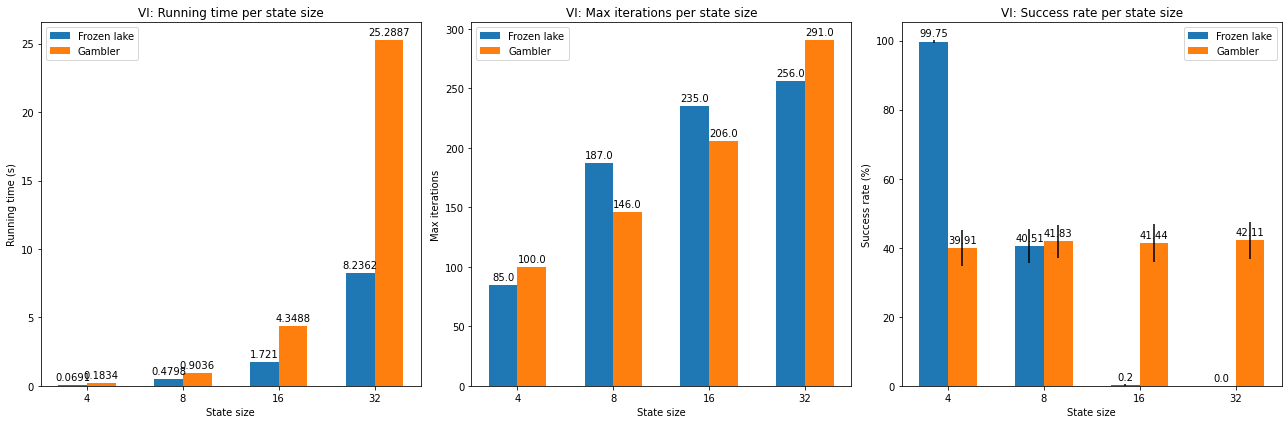

In [15]:
plot_all_comparison_bars(list_stats_frozen_lake_vi, list_stats_gambler_vi, 
                         list_xlabels=list_state_size, algo_type="VI")

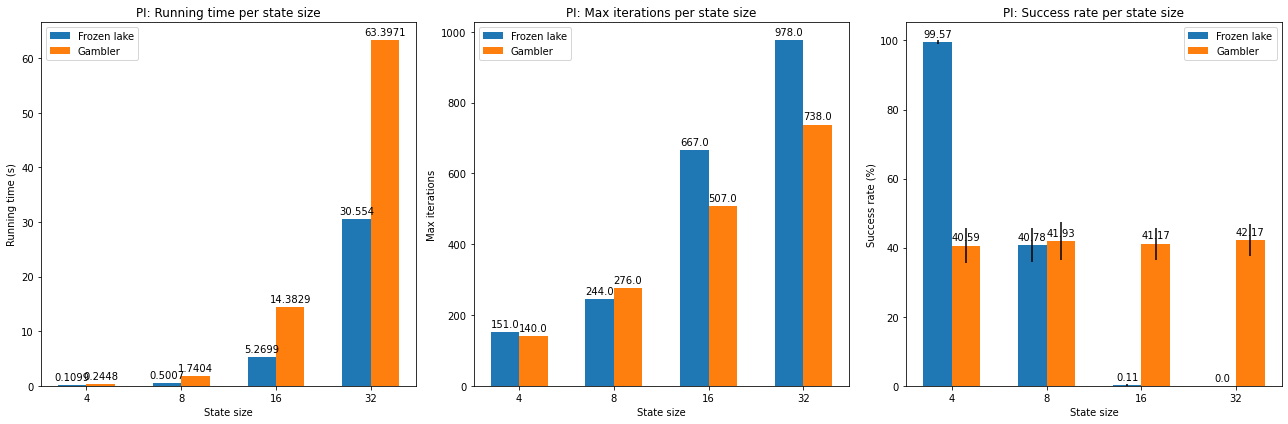

In [16]:
plot_all_comparison_bars(list_stats_frozen_lake_pi, list_stats_gambler_pi, 
                         list_xlabels=list_state_size, algo_type="PI")

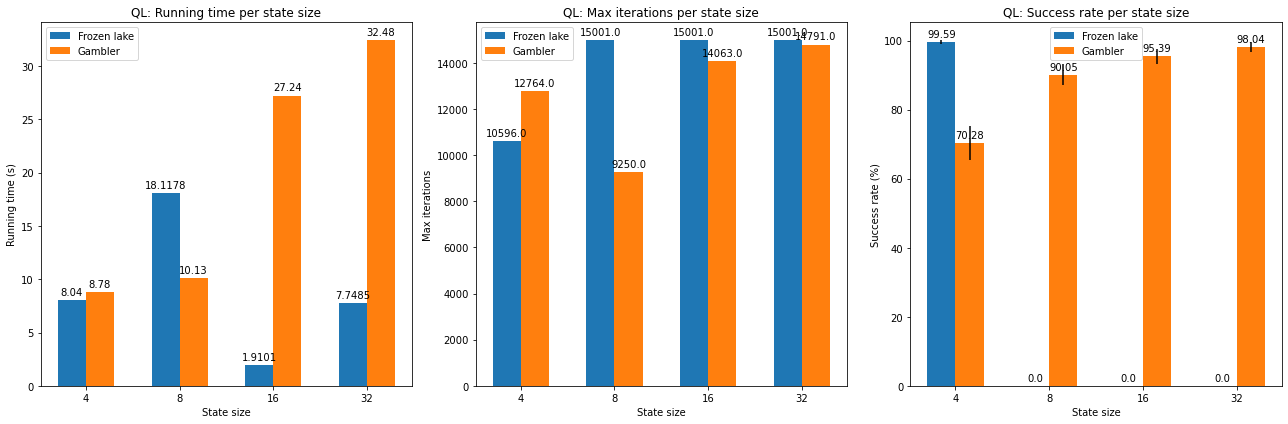

In [17]:
plot_all_comparison_bars(list_stats_frozen_lake_ql, list_stats_gambler_ql, 
                         list_xlabels=list_state_size, algo_type="QL")